#  Test on the synthetic dataset with non-uniform flows
- Author: Yong Lee (yongli.cv@gmail.com)
- Date: Sep 1st, 2021

In [1]:
import numpy as np
import cv2
from piv import PIV
from data import gen_image_pair
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from utils import tool
from tqdm import tqdm
from pathlib import Path 

sns.set_style()
sns.set()

plt.style.use('seaborn-dark-palette')


def read_flow(path):
    """Read the *.flo file """
    TAG_FLOAT = 202021.25
    with open(path) as f:
        raw = np.fromfile(f, np.float32)
        tag, width, height = raw[0:3]
        if tag !=TAG_FLOAT:
            raise ValueError(f"The check code for file({path}) is not correct")
        width = int.from_bytes(width.tobytes(),'little')
        height = int.from_bytes(height.tobytes(),'little')
        data = raw[3:]
        data = np.reshape(data, (width,height,2))
        u, v = np.split(data,2, -1)
    return u, v


def plot_field(u, v, method, v_min=0.0, v_max=12.0):
    u =-u.transpose()
    v = v.transpose()
    amp = np.sqrt(u**2+v**2)
    fig = plt.figure()
    plt.imshow(amp, cmap='jet', interpolation='bicubic', vmin=v_min, vmax=v_max)
    ax = fig.gca()
    ax.quiver(u,v, scale=800/(v_max-7.5)) 
    ax.set_title(method)
    ax.axis('equal')
    ax.axis('off')
    plt.colorbar()
    return fig

pls download the full dataset from https://github.com/shengzesnail/PIV_dataset
pls set the "win_sz = [64, 64]" to get the results for cylinder

TestImages/data/uniform
TestImages/data/JHTDB_channel_hd
TestImages/data/cylinder
TestImages/data/DNS_turbulence
TestImages/data/backstep
TestImages/data/SQG
(6, 201, 9, 1, 128)

 method: ['pc', 'spof', 'cfcc', 'scc', 'rpc', 'sbcc_b1', 'sbcc_b2', 'sbcc_b3', 'sbcc']
RMSE results:
uniform           :[  0.209   0.073   0.107   0.059   0.096   0.091   0.088   0.066   0.061]
JHTDB_channel_hd  :[  0.253   0.165   0.161   0.157   0.162   0.161   0.160   0.157   0.162]
cylinder          :[  7.012   7.004   7.003   7.003   7.003   7.003   7.003   7.003   7.003]
DNS_turbulence    :[  1.509   0.840   0.854   0.687   0.664   0.636   0.618   0.584   0.669]
backstep          :[  0.296   0.135   0.250   0.117   0.133   0.130   0.127   0.115   0.121]
SQG               :[  1.257   0.671   0.695   0.589   0.565   0.555   0.553   0.543   0.607]
outlier results:
u

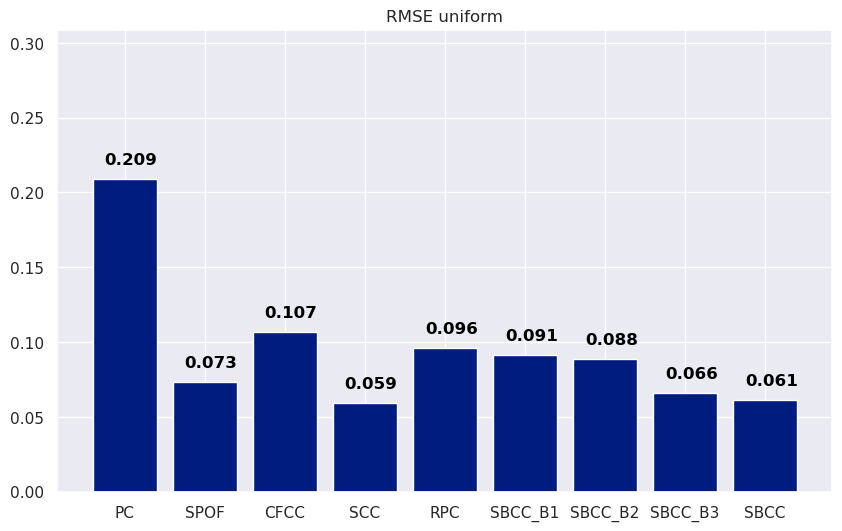

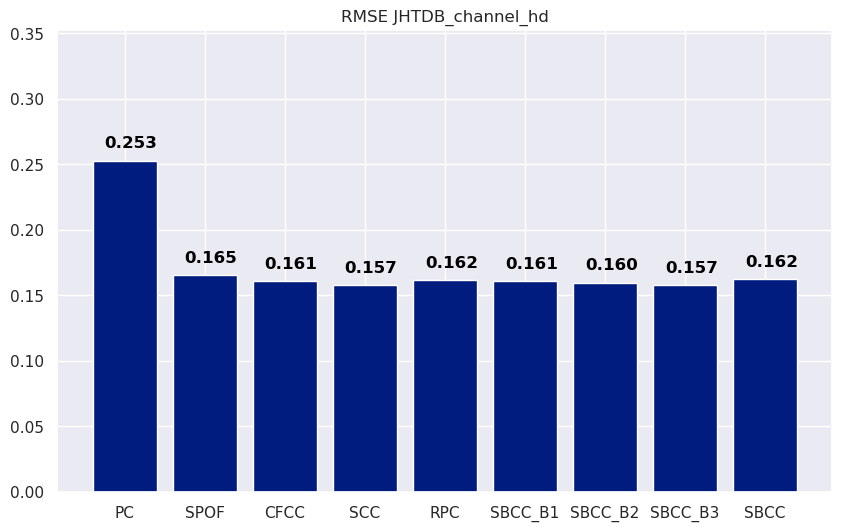

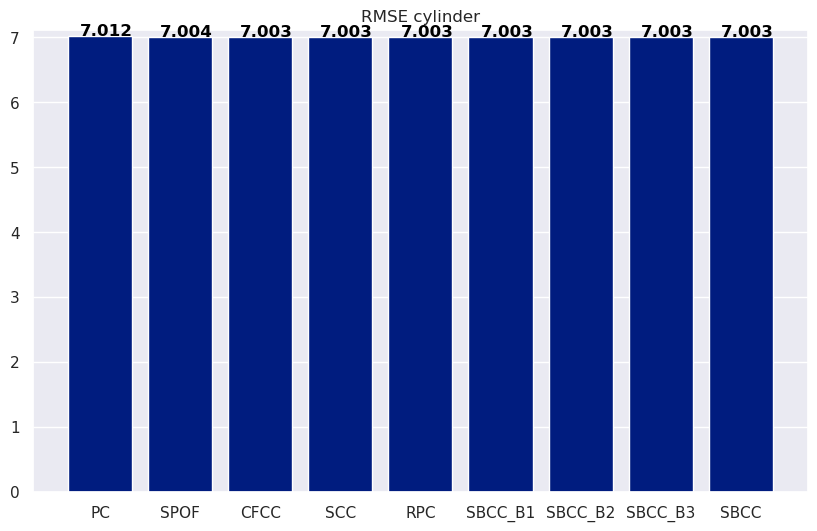

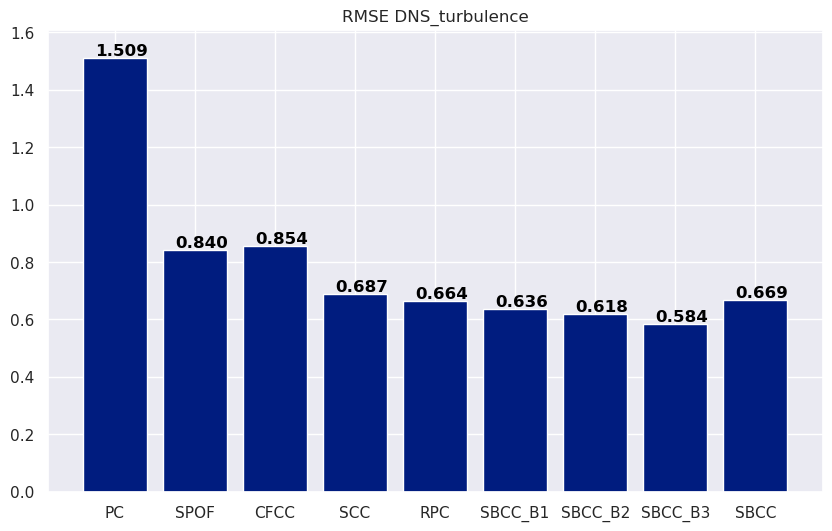

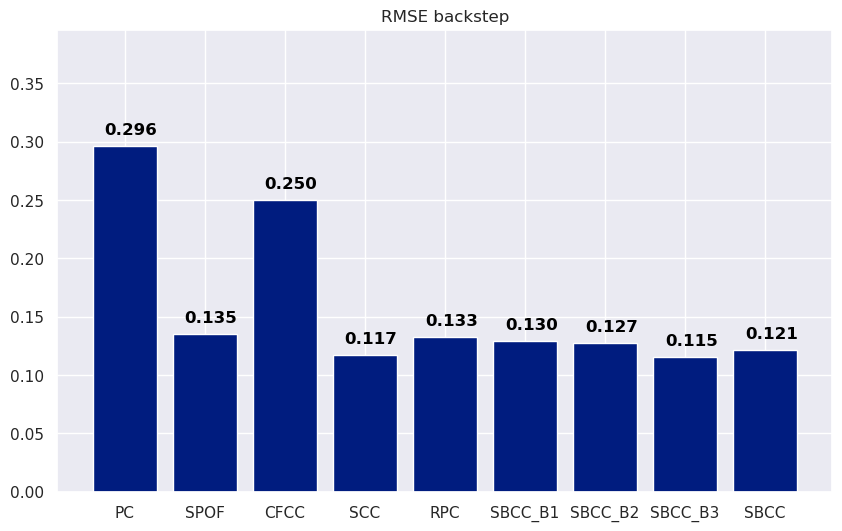

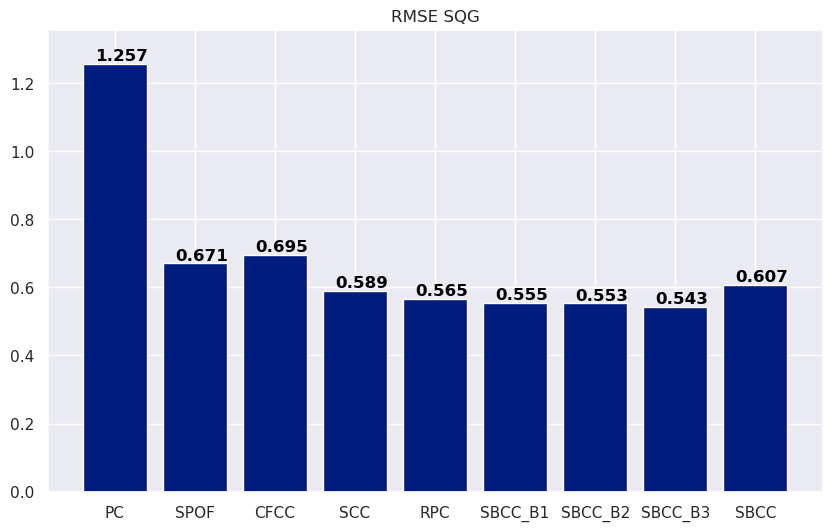

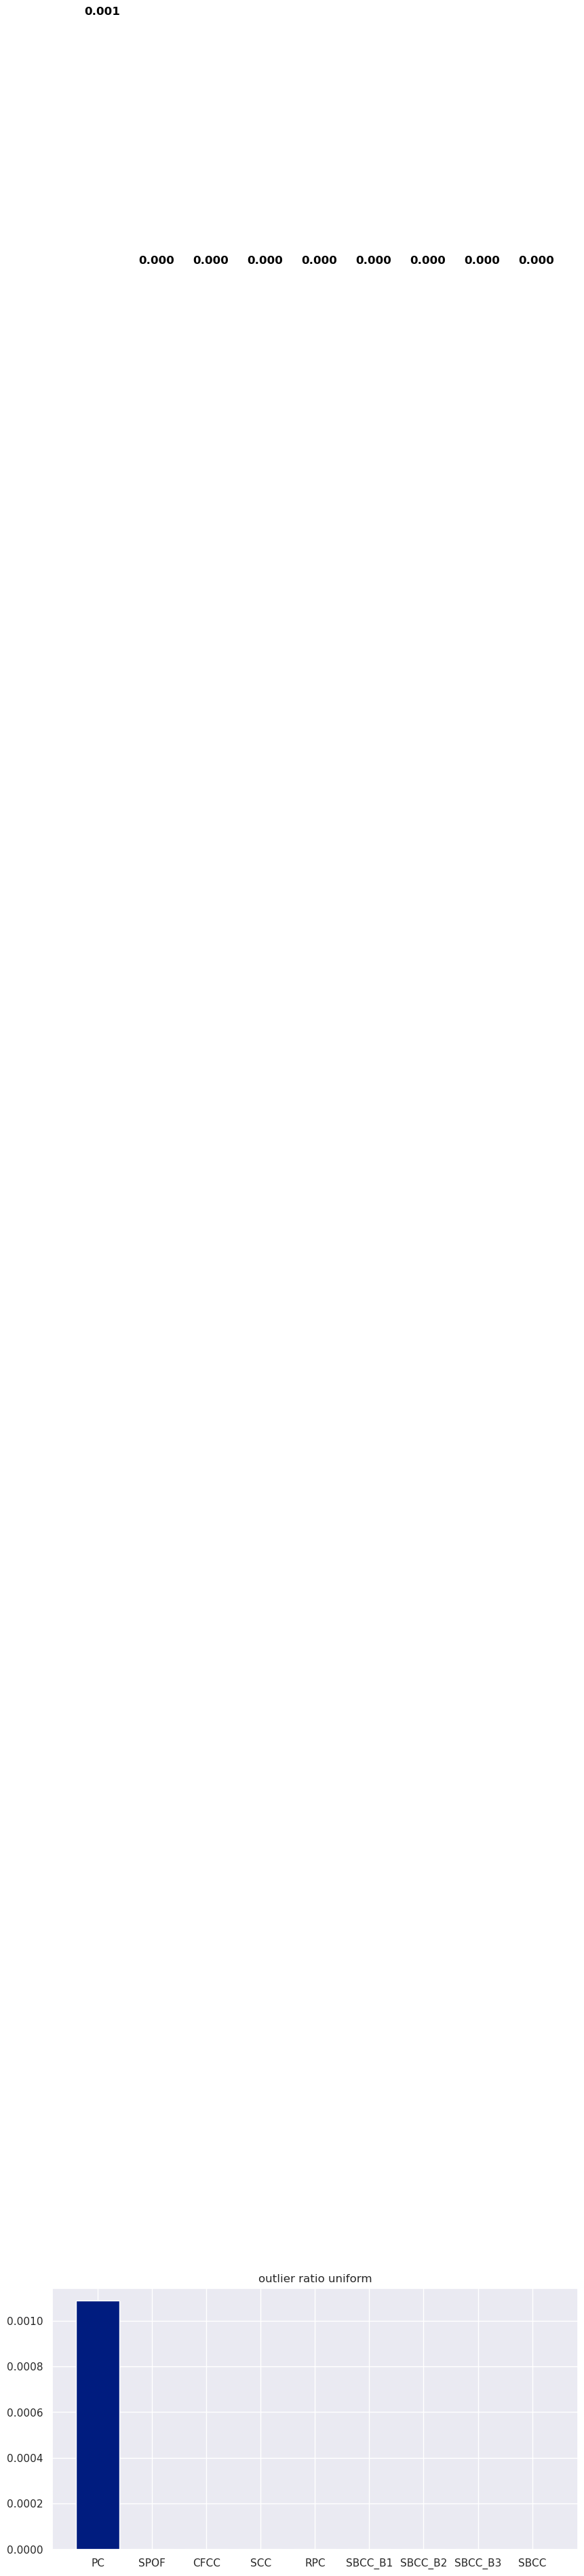

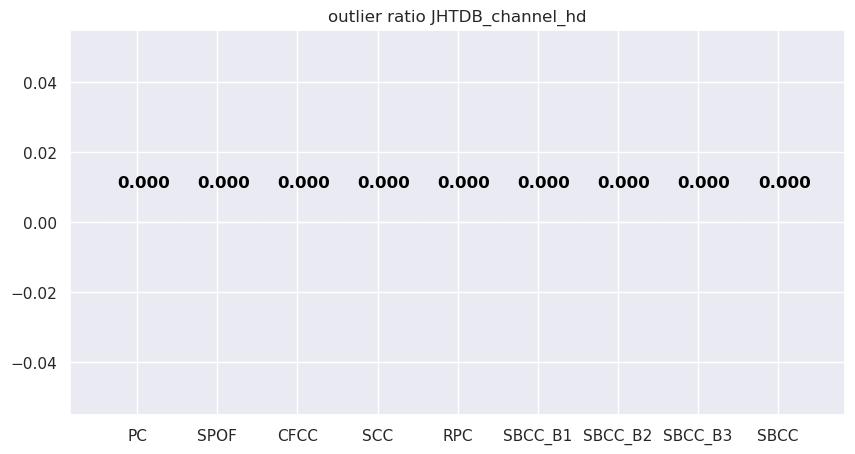

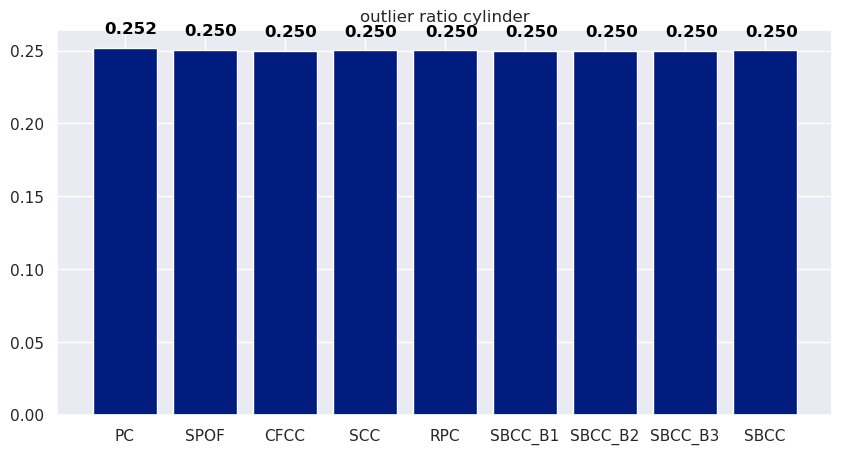

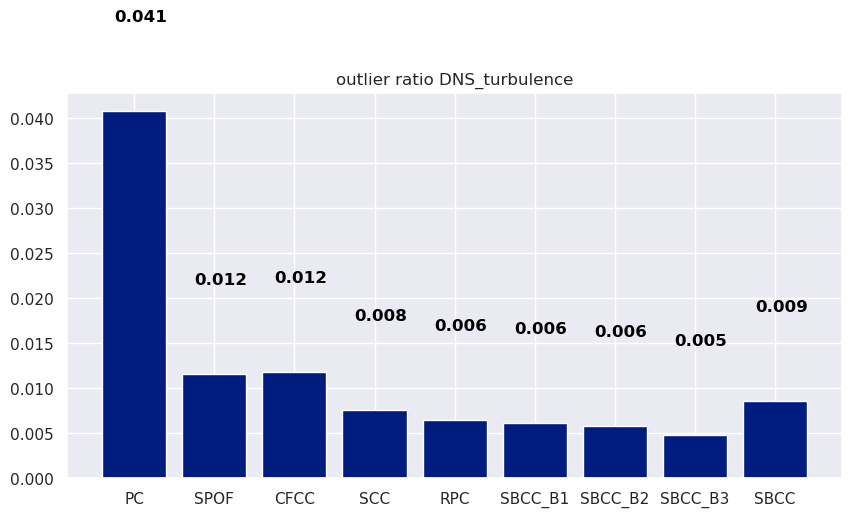

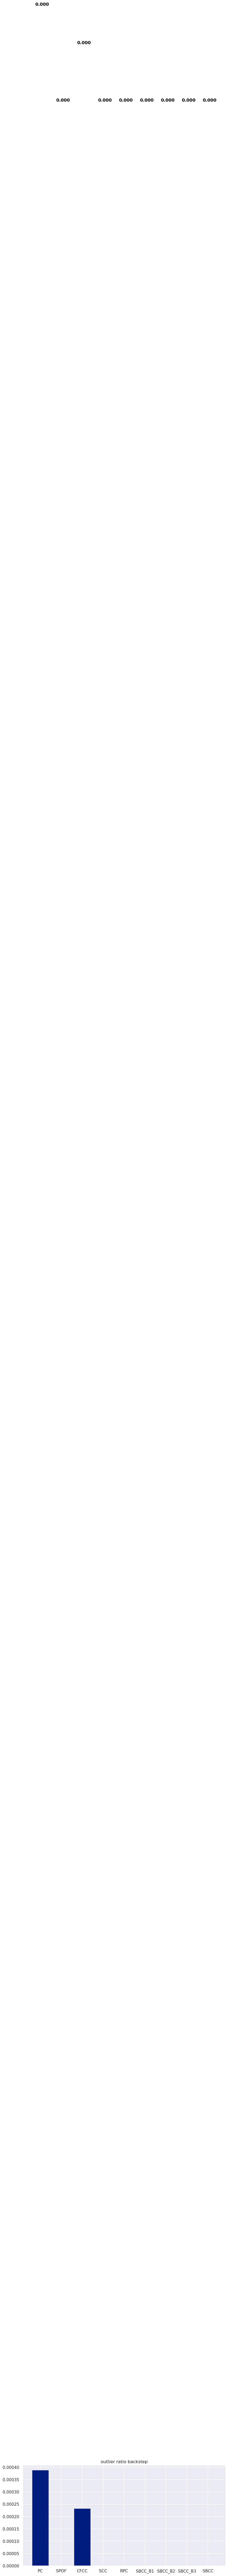

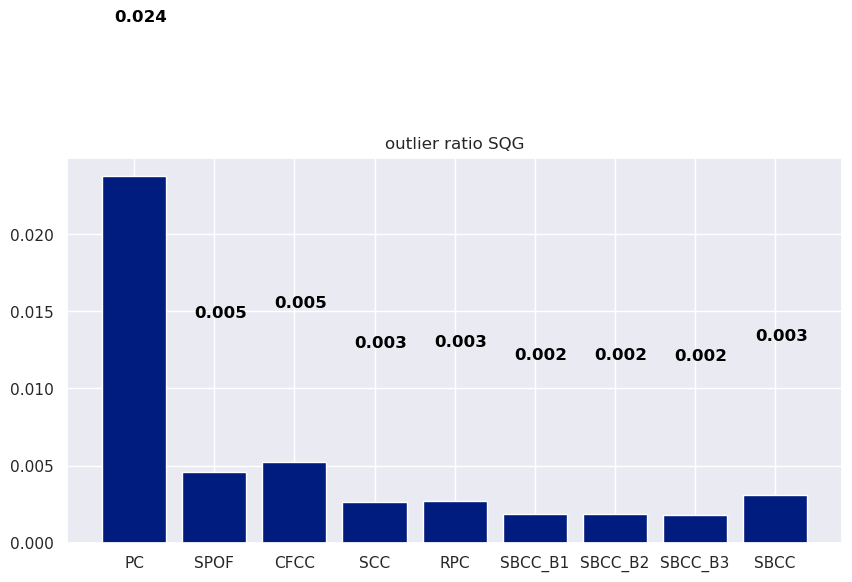

In [2]:
def main():
    print('pls download the full dataset from https://github.com/shengzesnail/PIV_dataset')
    print('pls set the "win_sz = [64, 64]" to get the results for cylinder\n')

    # methods and plot config
    method_list  =['pc', 'spof', 'cfcc', 'scc', 'rpc', 'sbcc_b1', 'sbcc_b2', 'sbcc_b3', 'sbcc']
    line_styles = [(0,(1,1)), (0,(3,1)), (0,(5,1)), (0,(8,1)), (0,(1,1,2,2)),
            (0,(1,1,1,1,1,1,4,1)), (0,(1,1,1,1,4,1)), (0,(1,1,4,1)), (0,())]
    colors = cm.Dark2(np.linspace(0,1,8))
    line_styles = dict(zip(method_list, line_styles))
    colors = dict(zip(method_list, colors))

    # config for piv 
    cfg_piv = tool.AttrDict()
    cfg_piv.win_sz = [32,32]
    # cfg_piv.win_sz = [64,64] # uncomment this for cylinder
    cfg_piv.runs = 1 
    cfg_piv.step_sz =[32,32]
    cfg_piv.subpixel='gaussian' # 'gaussian' # 'centroid' # 'parabolic'
    piv = PIV(cfg_piv)

    # datasets
    base_dir = Path('./TestImages/data/')

    bias, ratio = [], []
    flow_list = []
    MAX_NUM = 200

    for flow_dir in base_dir.iterdir():
        if flow_dir.is_file(): # check the tasks (uniform flow, cylinder,...)
            continue
        bias.append([])
        ratio.append([])
        flow_list.append(flow_dir.name)
        k = 0
        print(flow_dir)
 
#         flow_dir = sorted(flow_dir)
        for flow_name in flow_dir.iterdir():
            if flow_name.name.split('.')[-1] !='flo': # cleck the instances (case 1, case 2, ...)
                continue
            if k>MAX_NUM:
                continue
            else:
                k = k+1
            img1_name = flow_dir/flow_name.name.replace("flow.flo", "img1.tif") 
            img2_name = flow_dir/flow_name.name.replace("flow.flo", "img2.tif") 
            
            # read the data
            img1 = cv2.imread(str(img1_name),0)
            img2 = cv2.imread(str(img2_name),0)
            u_t, v_t = read_flow(flow_name)

            u_t_win,vel_shape = piv.grid_window(u_t)
            v_t_win,_ = piv.grid_window(v_t)
            ind1, ind2 = u_t_win.shape[0]//2+1, u_t_win.shape[1]//2+1
            u_t = u_t_win[ind1,ind2,:,:].reshape(vel_shape)
            v_t = v_t_win[ind1,ind2,:,:].reshape(vel_shape)

            bias[-1].append([])
            ratio[-1].append([])
            for j, method in enumerate(method_list):
                cfg_piv.method = method
                piv = PIV(cfg_piv)
                u, v, r_map= piv.compute(img2, img1)


                # err = (u-u_t)**2 + (v-v_t)**2
                err_u = np.abs(u-u_t)
                err_v = np.abs(v-v_t)
                mask= np.sqrt(err_u+err_v)>2.0
                # err_u[mask] = np.NaN
                # err_v[mask] = np.NaN
                err = np.concatenate([err_u, err_v])
                outlier = np.sum(mask)/np.prod(mask.shape)
                # print(f"{method:10s}\t{np.sqrt(np.nanmean(err)):.3f}\t outlier:{outlier:.4f}")
                bias[-1][-1].append([np.reshape(err,(-1))])
                ratio[-1][-1].append(outlier)
                # plot_field(u,v,method)
                # plot_field(u_t,v_t,"truth")
        #plt.show()
    bias= np.array(bias)
    print(bias.shape)
    # std = np.nanstd(np.sqrt(rmse/2), axis=(1,3,4)) # divide by 2 due to two components
    # rmse = np.sqrt(np.nanmean(rmse, axis=(1,3,4))/2) # divide by 2 due to two components
    std = np.nanstd(bias, axis=(1,3,4))
    mean = np.nanmean(bias, axis=(1,3,4))
    rmse= np.sqrt(np.nanmean(bias**2, axis=(1,3,4)))
    # rmse = np.sqrt(np.nanmean(rmse**2, axis=(1,3,4)))
    ratio = np.mean(np.array(ratio), axis=1)

    np.set_printoptions(formatter={'float': '{: 7.3f}'.format})
    print('\n method:',method_list)
    print("RMSE results:")
    for k, bar_data in enumerate(rmse):
        plt.figure(figsize=(10,6))
        # plt.yscale('log')
        label =[ met.upper() for met in method_list]
        plt.bar(label, bar_data)
        for i, v in enumerate(bar_data):
            plt.text(i - .25, v+0.01, f"{v:.3f}", color=(0,0,0), fontweight='bold')
        plt.ylim(0, np.max(bar_data)+0.1)
        plt.title("RMSE " + flow_list[k])
        # bar_data = np.round(bar_data, decimals=3)
        info = f"{flow_list[k]:18s}:{bar_data}"
        print(info)

        plt.savefig(f'output/{flow_list[k]}.pdf')
        plt.savefig(f'output/{flow_list[k]}.svg')
    print("outlier results:")
    for k, bar_data in enumerate(ratio):
        plt.figure(figsize=(10,5))
        label =[ met.upper() for met in method_list]
        plt.bar(label, bar_data)
        for i, v in enumerate(bar_data):
            plt.text(i - .25, v+0.01, f"{v:.3f}", color=(0,0,0), fontweight='bold')
        plt.title("outlier ratio "+flow_list[k])
        # bar_data = np.round(100*bar_data, decimals=2)
        info = f"{flow_list[k]:18s}:{100*bar_data}"
        print(info)

    plt.show()

main()